In [1]:
import time
import sys
import os
import dgl
import torch
from hydra.utils import to_absolute_path

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)
from python.create_dgl_dataset import TelemacDataset

from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMGNSimilarity import MeshGraphNet

In [2]:
# def create_dummy_graph():
#     # Create a graph with 9 nodes and 15 edges (randomly chosen)
#     num_nodes = 400000
#     num_edges = 2000000
#     src = torch.randint(0, num_nodes, (num_edges,))
#     dst = torch.randint(0, num_nodes, (num_edges,))

#     graph = dgl.graph((src, dst))

#     # Add node data: 9 nodes with 3 features in 'x' and 'y'
#     graph.ndata['x'] = torch.randn(num_nodes, 9)  # 9 features per node
#     graph.ndata['y'] = torch.randn(num_nodes, 3)  # 3 additional features per node

#     # Add edge data: 15 edges with 3 features in 'x'
#     graph.edata['x'] = torch.randn(num_edges, 3)  # 3 features per edge

#     return graph

# # Create the dummy graph
# dummy_graph = create_dummy_graph()

In [48]:
data_dir= '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Multimesh_16_32.bin'
dynamic_dir = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Group_3_peak_1600_Group_3_peak_1600_0_0-80_interpolated.pkl',
'/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Group_3_peak_2200_Group_3_peak_2200_0_0-80_interpolated.pkl',
'/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Group_3_peak_3200_Group_3_peak_3200_0_0-80_interpolated.pkl']
ckpt_path = "/work/m24046/m24046mrcr/new_tests_Group3/config1_short_x16_multimesh"

In [49]:
dataset = TelemacDataset(
            name="telemac_test",
            data_dir=data_dir,
            dynamic_data_files=dynamic_dir,
            split="train",
            ckpt_path=ckpt_path,
            normalize=True,
            sequence_length=1,
            overlap=0
        )

Normalizing data...


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_test = MeshGraphNet(9,
            3,
            3,
            processor_size=10,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=True,
            num_processor_checkpoint_segments=0,)

model_test=model_test.to(device)

load_checkpoint(
            to_absolute_path(ckpt_path),
            models=model_test,
            device=device,
            epoch=2000,
        )

[22:09:24 - checkpoint - INFO] Loaded model state dictionary /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x16_multimesh/MeshGraphNet.0.2000.mdlus to device cuda
[22:09:24 - checkpoint - INFO] Loaded checkpoint file /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x16_multimesh/checkpoint.0.2000.pt to device cuda


2000

In [51]:
def compute_dirichlet_energy(graph: dgl.DGLGraph) -> torch.Tensor:
    """
    Compute the Dirichlet energy for the graph's node features.
    
    The node features are stored in graph.ndata['x'].
    
    Parameters
    ----------
    graph : dgl.DGLGraph
        The graph containing node features `x` and edges.

    Returns
    -------
    torch.Tensor
        The computed Dirichlet energy (a scalar).
    """
    with graph.local_scope():
        # Node features
        node_features = graph.ndata['x']
        
        # Broadcast node features to edges
        graph.ndata['x'] = node_features
        graph.apply_edges(lambda edges: {
            'diff': edges.src['x'] - edges.dst['x']  # Compute differences between connected nodes
        })
        
        # Compute squared L2 norm for each edge
        graph.edata['squared_diff'] = torch.sum(graph.edata['diff'] ** 2, dim=-1)
        
        # Sum over all edges and normalize by the number of nodes
        dirichlet_energy = graph.edata['squared_diff'].sum() / graph.num_nodes()
    
    return dirichlet_energy



In [52]:
mean_dirichlet_energy = 0
for graphs in dataset : 
    graph = graphs[0]
    mean_dirichlet_energy += compute_dirichlet_energy(graph).item()
mean_dirichlet_energy = mean_dirichlet_energy/len(dataset)
print(mean_dirichlet_energy)

2019.1640821887602


In [53]:
import numpy as np

In [54]:
energies = np.zeros((10,))
# Create a dummy graph

for graphs in dataset :
    graph = graphs[0]

    # Extract node and edge features
    node_features = graph.ndata['x']
    edge_features = graph.edata['x']

    # Run the model
    with torch.no_grad():
        output, dirichlet_energies = model_test(node_features.to(device), edge_features.to(device),graph.to(device))
        energies += np.array(dirichlet_energies)
energies = energies/len(dataset)
print("Dirichlet Energies at each message passing step:", energies)


Dirichlet Energies at each message passing step: [ 689.34100965 1009.59685032 1249.16464069 1533.2437311  1877.18169182
 2159.42861774 2575.33295268 3138.02594979 3575.60823568 4173.45371041]


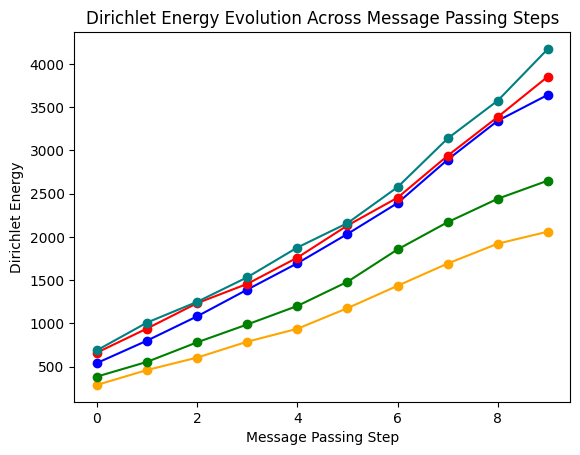

In [55]:
import matplotlib.pyplot as plt

dirichlet_energiesx16 = [689.34100965 ,1009.59685032 ,1249.16464069 ,1533.2437311  ,1877.18169182,
 2159.42861774 ,2575.33295268, 3138.02594979, 3575.60823568, 4173.45371041]

dirichlet_energiesx8 = [ 662.54186027 , 940.82715303 ,1234.05742161 ,1456.85492272 ,1760.29911033,
 2132.10298797 ,2453.28657909 ,2938.76155074 ,3387.04116001 ,3853.9160655 ]

dirichlet_energiesx4 = [ 542.05840638 , 801.01259621, 1081.89054493 ,1390.71701214 ,1695.41019169,
 2034.16701713, 2391.28553952, 2893.2312038,  3342.76088395, 3642.61015467]

dirichlet_energiesx2 = [ 385.21739509 , 555.33050045 , 781.2677422  , 987.77496994, 1201.71866993,
 1480.99044308, 1855.08298681 ,2170.39833512, 2441.22237273, 2650.7789661 ]

dirichlet_energiesx1 = [288.68312795 , 460.97332534  ,604.86487506 , 788.40967519 , 937.92551283,
 1176.34785839 ,1434.88144347 ,1692.133814   ,1921.7606805 , 2060.9648595]

plt.plot(range(len(energies)), dirichlet_energiesx1, marker='o',color='orange',label='')
plt.plot(range(len(energies)), dirichlet_energiesx2, marker='o',color='green')
plt.plot(range(len(energies)), dirichlet_energiesx4, marker='o',color='blue')
plt.plot(range(len(energies)), dirichlet_energiesx8, marker='o',color='red')
plt.plot(range(len(energies)), dirichlet_energiesx16, marker='o',color='teal')

plt.xlabel('Message Passing Step')
plt.ylabel('Dirichlet Energy')
plt.title('Dirichlet Energy Evolution Across Message Passing Steps')
plt.show()


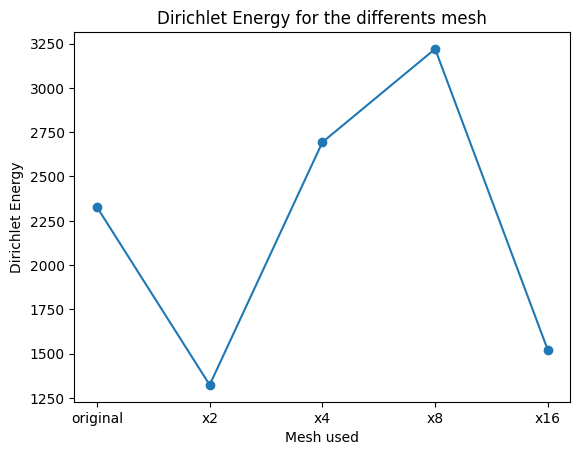

In [86]:
import matplotlib.pyplot as plt

simple = [2327.33,1323.69,2693.51,3220,1520]
plt.plot(['original','x16','x16','x16','x16'], simple, marker='o')
plt.xlabel('Mesh used')
plt.ylabel('Dirichlet Energy')
plt.title('Dirichlet Energy for the differents mesh')
plt.show()


In [2]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/c4/64/7d344cfcef5efddf9cf32f59af7f855828e9d74b5f862eddf5bfd9f25323/geopandas-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhosted.org/packages/a6/07/35e4127a878ecdcbaaf46f0f2d068b385a454b5b0cab44ea901adc5888a0/pyogrio-0.10.0-cp310-cp310-manylinux_2_28_aarch64.whl.metadata
  Obtaining dependency information for pyproj>=3.3.0 from https://files.pythonhosted.org/packages/f8/0d/d300194f021e3d56b30bb45bd19447bb00761c62f5342371bd389b774f82/pyproj-3.7.0-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
  Obtaining dependency information for shapely>=2.0.0 from https://files.pythonhosted.org/packages/af/09/6374c11cb493a9970e8c04d7be25f578a37f6494a2fecfbed3a447b16b2c/shapely-2.0.6-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metada